<a href="https://colab.research.google.com/github/ldsAS/Tibame-AI-Learning/blob/main/Tibame20250618_LAB_HR_%E8%A8%93%E7%B7%B4%E6%A8%A1%E5%BC%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 人員資料 預測離職 分類問題

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
class AutoPreprocess:
    def __init__(self):
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []

    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names

        for fname in field_names:
            #自動補空值
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
                # self.fillna_value[fname] = 'np.nan'
                # self.fillna_value[fname] = np.nan # 維持空值
            elif data[fname].dtype == bool: #布林型態
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
            else: # 數字型態
                self.fillna_value[fname] = data[fname].median()  #補中位數

            #自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                pass #不用轉換
            elif data[fname].dtype == bool: #布林型態
                pass #不用轉換
            else: # 數字型態
                vc = data[fname].value_counts()
                if data[fname].isin([0, 1]).all(): #當數值只有0跟1
                    pass #不用轉換
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10: #是否簡單的整數型類別且數量小於10
                    self.scaler[fname] = MinMaxScaler()
                    self.scaler[fname].fit(data[[fname]])
                else: #其他的數字型態
                    self.scaler[fname] = StandardScaler()
                    self.scaler[fname].fit(data[[fname]])


            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = fname+"_"+value
                    # data[fn] = (data[fname] == value).astype('int8')
                    self.final_field_names.append(fn)
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                # data[fname] = data[fname].astype(int)
                self.final_field_names.append(fname)
            else: # 數字型態 不用重新編碼
                self.final_field_names.append(fname)

        return

    def transform(self, data):
        #如果輸入的data是dict，要先轉成dataframe
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else: #將資料複製一份，不修改原本的資料
            data = data.copy()

        for fname in self.field_names:
            #自動補空值
            if data[fname].isnull().any(): #有空值
                # if fname in self.fillna_value:
                    data[fname] = data[fname].fillna(self.fillna_value[fname])


            #自動尺度轉換(scaling)
            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])

            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                if fname in self.onehotencode_value:
                    field_value = self.onehotencode_value[fname]
                for value in field_value:
                    fn = fname+"_"+value
                    data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                data[fname] = data[fname].astype(int)
            else: # 數字型態 不用重新編碼
                pass
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)

In [3]:
#載入訓練用資料
import pandas as pd
import numpy as np
data = pd.read_csv('../content/R公司_人員資料_train.csv')
data.head()

,員工編號(EmployeeNumber),性別(Gender),年齡(Age),是否為成年人(Over18),婚姻狀態(MaritalStatus),通勤距離(DistanceFromHome),教育程度(Education),教育專業領域(EducationField),部門(Department),職位名稱(JobRole),...,股票選擇權等級(StockOptionLevel),績效評估(PerformanceRating),出差頻率(BusinessTravel),去年訓練時間(TrainingTimesLastYear),工作滿意度(JobSatisfaction),工作環境滿意度(EnvironmentSatisfaction),工作投入(JobInvolvement),工作生活平衡(WorkLifeBalance),人際關係滿意度(RelationshipSatisfaction),離職(Attrition)
0,1551,Male,24,Y,Divorced,21,2,Technical Degree,Research & Development,Laboratory Technician,...,3,3,Travel_Rarely,3,1,3,2,3,2,No
1,1012,Male,18,Y,Single,5,2,Life Sciences,Research & Development,Research Scientist,...,0,3,Non-Travel,2,4,2,3,3,4,No
2,349,Male,29,Y,Divorced,20,2,Marketing,Sales,Sales Executive,...,1,3,Travel_Rarely,2,4,4,3,3,4,No
3,1654,Male,39,Y,Married,12,3,Medical,Research & Development,Manufacturing Director,...,0,4,Travel_Rarely,3,2,4,3,3,3,No
4,1881,Male,31,Y,Divorced,20,3,Life Sciences,Research & Development,Laboratory Technician,...,1,3,Travel_Rarely,2,3,2,3,3,1,No


In [4]:
data.columns

Index(['員工編號(EmployeeNumber)', '性別(Gender)', '年齡(Age)', '是否為成年人(Over18)',
       '婚姻狀態(MaritalStatus)', '通勤距離(DistanceFromHome)', '教育程度(Education)',
       '教育專業領域(EducationField)', '部門(Department)', '職位名稱(JobRole)',
       '職位等級(JobLevel)', '在該公司工作總年資(YearsAtCompany)',
       '在該職位工作年資(YearsInCurrentRole)', '在該職等工作年資(YearsSinceLastPromotion)',
       '與現任管理者工作年資(YearsWithCurrManager)', '總工作年資(TotalWorkingYears)',
       '過去工作公司家數(NumCompaniesWorked)', '每日工資額(DailyRate)',
       '每小時工資額(HourlyRate)', '月收入(MonthlyIncome)', '月費率(MonthlyRate)',
       '標準工作時間(StandardHours)', '加班(OverTime)', '調薪百分比(PercentSalaryHike)',
       '股票選擇權等級(StockOptionLevel)', '績效評估(PerformanceRating)',
       '出差頻率(BusinessTravel)', '去年訓練時間(TrainingTimesLastYear)',
       '工作滿意度(JobSatisfaction)', '工作環境滿意度(EnvironmentSatisfaction)',
       '工作投入(JobInvolvement)', '工作生活平衡(WorkLifeBalance)',
       '人際關係滿意度(RelationshipSatisfaction)', '離職(Attrition)'],
      dtype='object')

In [5]:
data['離職(Attrition)_Num'] = data['離職(Attrition)'].map({'Yes':1, 'No':0})

In [7]:
data.shape

(1176, 35)

In [8]:
ap = AutoPreprocess()
ap.fit(data, ['性別(Gender)', '年齡(Age)', '是否為成年人(Over18)',
       '婚姻狀態(MaritalStatus)', '通勤距離(DistanceFromHome)', '教育程度(Education)',
       '教育專業領域(EducationField)', '部門(Department)', '職位名稱(JobRole)',
       '職位等級(JobLevel)', '在該公司工作總年資(YearsAtCompany)',
       '在該職位工作年資(YearsInCurrentRole)', '在該職等工作年資(YearsSinceLastPromotion)',
       '與現任管理者工作年資(YearsWithCurrManager)', '總工作年資(TotalWorkingYears)',
       '過去工作公司家數(NumCompaniesWorked)', '每日工資額(DailyRate)',
       '每小時工資額(HourlyRate)', '月收入(MonthlyIncome)', '月費率(MonthlyRate)',
       '標準工作時間(StandardHours)', '加班(OverTime)', '調薪百分比(PercentSalaryHike)',
       '股票選擇權等級(StockOptionLevel)', '績效評估(PerformanceRating)',
       '出差頻率(BusinessTravel)', '去年訓練時間(TrainingTimesLastYear)',
       '工作滿意度(JobSatisfaction)', '工作環境滿意度(EnvironmentSatisfaction)',
       '工作投入(JobInvolvement)', '工作生活平衡(WorkLifeBalance)',
       '人際關係滿意度(RelationshipSatisfaction)'])
ap.save("preprocess.bin")

X = ap.transform(data)
y = data['離職(Attrition)_Num']

In [ ]:
X.columns

Index(['性別(Gender)_Male', '性別(Gender)_Female', '年齡(Age)', '是否為成年人(Over18)_Y',
       '婚姻狀態(MaritalStatus)_Married', '婚姻狀態(MaritalStatus)_Single',
       '婚姻狀態(MaritalStatus)_Divorced', '通勤距離(DistanceFromHome)',
       '教育程度(Education)', '教育專業領域(EducationField)_Life Sciences',
       '教育專業領域(EducationField)_Medical', '教育專業領域(EducationField)_Marketing',
       '教育專業領域(EducationField)_Technical Degree',
       '教育專業領域(EducationField)_Other',
       '教育專業領域(EducationField)_Human Resources',
       '部門(Department)_Research & Development', '部門(Department)_Sales',
       '部門(Department)_Human Resources', '職位名稱(JobRole)_Sales Executive',
       '職位名稱(JobRole)_Research Scientist',
       '職位名稱(JobRole)_Laboratory Technician',
       '職位名稱(JobRole)_Manufacturing Director',
       '職位名稱(JobRole)_Healthcare Representative', '職位名稱(JobRole)_Manager',
       '職位名稱(JobRole)_Sales Representative', '職位名稱(JobRole)_Research Director',
       '職位名稱(JobRole)_Human Resources', '職位等級(JobLevel)',
       '在該公司工

In [9]:
from sklearn.model_selection import train_test_split
# 分割資料成訓練組跟驗證組
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [10]:
from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier()

from sklearn.neural_network import MLPClassifier
model = MLPClassifier()

model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [11]:
# 驗證模型
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

y_pred = model.predict(X_train)
f1 = f1_score(y_train, y_pred)
print("訓練組 f1:", f1)
precision = precision_score(y_train, y_pred)
print("訓練組 precision:", precision)
recall = recall_score(y_train, y_pred)
print("訓練組 recall:", recall)

y_pred = model.predict_proba(X_train)[:,1]
roc_auc = roc_auc_score(y_train, y_pred)
print("訓練組 roc_auc:", roc_auc)

y_pred2 = model.predict(X_valid)
f1 = f1_score(y_valid, y_pred2)
print("驗證組 f1:", f1)
precision = precision_score(y_valid, y_pred2)
print("驗證組 precision:", precision)
recall = recall_score(y_valid, y_pred2)
print("驗證組 recall:", recall)

y_pred2 = model.predict_proba(X_valid)[:,1]
roc_auc = roc_auc_score(y_valid, y_pred2)
print("驗證組 roc_auc:", roc_auc)

訓練組 f1: 0.962457337883959
訓練組 precision: 0.986013986013986
訓練組 recall: 0.94
訓練組 roc_auc: 0.9976775956284153
驗證組 f1: 0.5581395348837209
驗證組 precision: 0.631578947368421
驗證組 recall: 0.5
驗證組 roc_auc: 0.8054708672086721


驗證組 precision: 0.8125
驗證組 recall: 0.2708333333333333


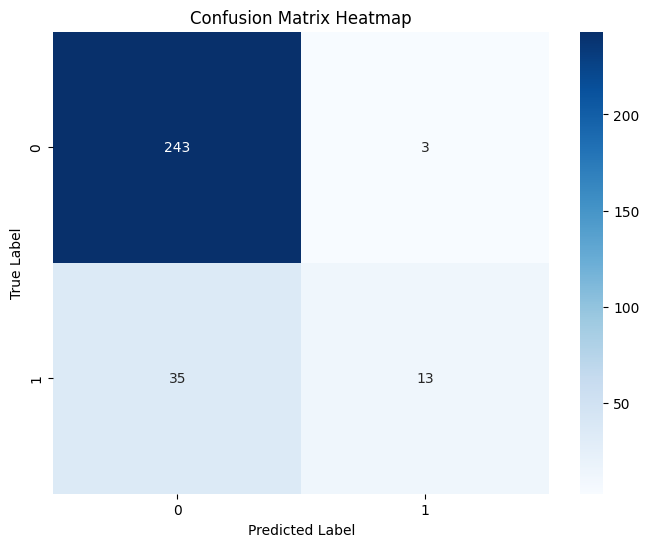

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 調整threshold來觀察precision與recall
threshold = 0.9

# 預測結果
y_pred_proba = model.predict_proba(X_valid)[:,1]
y_pred = (y_pred_proba >= threshold).astype('int')

precision = precision_score(y_valid, y_pred)
print("驗證組 precision:", precision)
recall = recall_score(y_valid, y_pred)
print("驗證組 recall:", recall)

# 計算混淆矩陣
cm = confusion_matrix(y_valid, y_pred)

# 繪製 heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
